<a href="https://colab.research.google.com/github/jonas-bischofberger/accessible-space/blob/main/accessible_space/apps/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: Dangerous Accessible Space / Physical pass simulation

This notebook shows you how to calculate an <b>Expected Pass Completion</b> rate (risk of a pass) and <b>Dangerous Accessible Space (DAS)</b> (which corresponds to the value of a situation) using a <b>physical simulation</b> of the ball and player kinematics. The model was published by Bischofberger & Baca (2025)$^1$, building on the physical pass simulation model by Spearman, Basye, Dick, Hotovy, and Pop (2017)$^2$. DAS achieves 74% accuracy on the OJN-EPV benchmark (Overmeer, Janssen, & Nuijten, 2025)$^3$ which shows that it has a strong ability to capture how the detailed setup of a constellation within a football game affect its expected attacking threat.

This tutorial focuses on the conceptual modeling approach behind DAS and walks you through the calculation of the metric for one particular example. The complete implementation can be found in the source code of the <b>accessible-space</b> package$^4$.

$^1$ Not yet published

$^2$ Spearman, W., Basye, A., Dick, G., Hotovy, R., & Pop, P. (2017). Physics-based modeling of pass probabilities in soccer. 11th MIT Sloan Sports Analytics Conference. https://static.hudl.com/craft/downloads/SSAC17-Physics-Based-Modeling-of-Pass-Probabilities-in-Soccer.pdf

$^3$ Overmeer, T., Janssen, T., & Nuijten, W. (2025). Revisiting expected possession value in football: Introducing a benchmark, U-Net architecture, and reward and risk for passes. https://doi.org/10.48550/arXiv.2502.02565

$^4$ https://github.com/jonas-bischofberger/accessible-space

### 1. Preparations

We use pandas, numpy and scipy for calculating the model, and matplotlib and databallpy for visualization.

In [22]:
!pip install databallpy
!pip install accessible_space

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.5 MB/s eta 0:00:00


In [23]:
import collections
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate

import databallpy.visualize

First, we prepare a dummy frame of tracking data which we will use to simulate a single pass. This pass has the initial parameters ```pass_angle``` $ = 45° = \frac{\pi}{4}$ and ```pass_speed``` $ = 15 \frac{m}{s}$

In [24]:
# Tracking data
df = pd.DataFrame({
    "frame_id": [0, 0, 0, 0, 0],
    "player": ["a", "x", "b", "y"] + ["ball"],
    "x": [-1, 10, 20, 50] + [0],
    "y": [0, 5, 27.5, -20] + [0],
    "vx": [0, 2, 0, 0] + [0],
    "vy": [0, 0, 0, 0] + [0],
    "team": ["H", "A", "H", "A"] + ["ball"],
    "player_color": ["blue", "orange", "red", "green", "black"],
    "team_in_possession": ["H", "H", "H", "H", "H"],
})
players = df["player"][:-1].values
players_x = df["x"][:-1].values
players_y = df["y"][:-1].values
players_vx = df["vx"][:-1].values
players_vy = df["vy"][:-1].values
teams = df["team"][:-1].values
passer = "a"  # player index of the passer
passer_team = teams[players == passer][0]
player_colors = df["player_color"][:-1].values
ball_x0 = df["x"].iloc[-1]
ball_y0 = df["y"].iloc[-1]

# Parameters of the pass to be simulated
pass_speed = 15
pass_angle = math.pi/4

# Some namedtuples to access matplotlib plots a nice way
FigAx = collections.namedtuple("FigAx", ["fig", "ax"])
Figs = collections.namedtuple("Figs", ["plot3d", "plot2d"])

df

,frame_id,player,x,y,vx,vy,team,player_color,team_in_possession
0,0,a,-1,0.0,0,0,H,blue,H
1,0,x,10,5.0,2,0,A,orange,H
2,0,b,20,27.5,0,0,H,red,H
3,0,y,50,-20.0,0,0,A,green,H
4,0,ball,0,0.0,0,0,ball,black,H


Next, we define helper functions for visualisation. One of these is will create a 3D plot that will help us later to reveal various quantities as they evolve along the trajectory of the pass. The other one uses ```databallpy```'s ```visualize``` module to create a 2D plot.

In [25]:
def plot_constellation_2d():
    plt.figure()
    databallpy.visualize.plot_soccer_pitch()
    for team in np.unique(teams):
        color = {"H": "blue", "A": "red"}[team]
        team_players_x = players_x[teams == team]
        team_players_y = players_y[teams == team]
        plt.scatter(team_players_x, team_players_y, label=f"{team} Players", color=color, s=150)

        team_players_vx = players_vx[teams == team]
        team_players_vy = players_vy[teams == team]
        for x, y, vx, vy in zip(team_players_x, team_players_y, team_players_vx, team_players_vy):
            if vx == 0 and vy == 0:
                continue
            plt.arrow(x, y, vx, vy, head_width=1, head_length=1, fc=color, ec=color)

        # plot player names
        for i, player in enumerate(players):
            if teams[i] != team:
                continue
            plt.text(players_x[i], players_y[i]-2, player, fontsize=20, ha="center", va="top", color=color, weight="bold")

    plt.scatter(ball_x0, ball_y0-0.5, label="Ball", color="black", s=500, marker="x", linewidths=4)


def three_d_plot(name_minus_z=-0.75):
    ax = plt.axes(projection='3d')
    ax.set_zlim(0, 1)

    # draw pitch
    ax.plot([-52.5, -52.5], [-34, 34], [0, 0], color="grey")
    ax.plot([52.5, 52.5], [-34, 34], [0, 0], color="grey")
    ax.plot([-52.5, 52.5], [-34, -34], [0, 0], color="grey")
    ax.plot([-52.5, 52.5], [34, 34], [0, 0], color="grey")

    # middle line
    ax.plot([0, 0], [-34, 34], [0, 0], color="grey")

    # middle circle
    theta = np.linspace(0, 2 * np.pi, 100)
    x = 9 * np.cos(theta)
    y = 9 * np.sin(theta)
    ax.plot(x, y, 0, color="grey")

    # Penalty box
    ax.plot([-52.5, -52.5+16.5], [-16.5-7.32/2, -16.5-7.32/2], [0, 0], color="grey")
    ax.plot([-52.5, -52.5+16.5], [16.5+7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([-52.5+16.5, -52.5+16.5], [-16.5-7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([-52.5+16.5, -52.5+16.5], [16.5+7.32/2, -16.5-7.32/2], [0, 0], color="grey")

    # Other penalty box
    ax.plot([52.5, 52.5-16.5], [-16.5-7.32/2, -16.5-7.32/2], [0, 0], color="grey")
    ax.plot([52.5, 52.5-16.5], [16.5+7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([52.5-16.5, 52.5-16.5], [-16.5-7.32/2, 16.5+7.32/2], [0, 0], color="grey")
    ax.plot([52.5-16.5, 52.5-16.5], [16.5+7.32/2, -16.5-7.32/2], [0, 0], color="grey")

    # give z axis independent aspect
    ax.set_box_aspect([52.5*2, 34*2, 100])

    for player in players:
        player_index = np.where(players == player)[0][0]
        player_color = player_colors[player_index]
        ax.scatter(players_x[player_index], players_y[player_index], 0, color=player_color, alpha=1)
        ax.text(players_x[player_index], players_y[player_index], name_minus_z, player, color=player_color, fontsize=12, ha="center", va="center")

    return ax

Let's finish our preparations by having a look at the dummy tracking data consisting of two players for each team and the ball.

<Figure size 640x480 with 0 Axes>

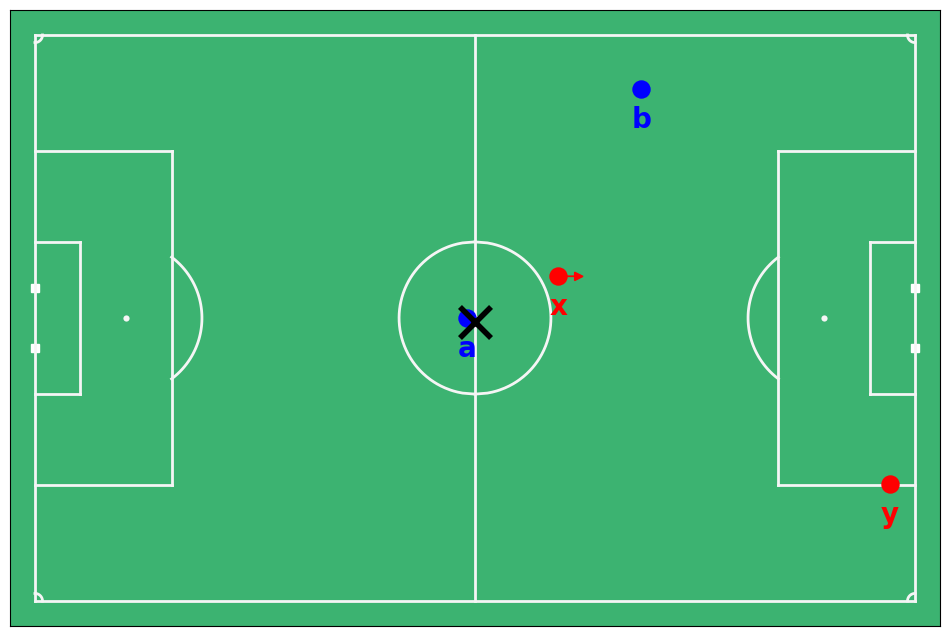

In [26]:
plot_constellation_2d()

### Calculating the model

The idea behind the simulation is to think about the pass as a process that can transition between different states. The pass begins in the state "Not intercepted" and at some point transitions into a state "Intercepted by player X" once player X successfully intercepts (defender) or receives (attacker) the pass. The transitions from "Not intercepted" to intercepted are predicted using probabilities or, more precisely, transition rates (= probability densities over time). The transition rate (or <b>interception rate</b>) of a particular player depends on how quickly they can reach the ball while it rolls along the grass - the earlier a player arrives before the ball, the higher the interception rate and the higher their probability to intercept the pass.

This setup is called a <b>Markov process</b> and gives you differential equations that describe the probabilities of the pass being in each state over time. These differential equations look like this:

$$
\frac{dP_0(t)}{dt} = -P_0(t) \sum_{r \in R} a_r(t)
$$

$$
\text{for all } r \in R: \quad \frac{dP_r(t)}{dt} = P_0(t) a_r(t)
$$

Where $P_0$ is the probability of the ball being "Not intercepted", $t$ is the time during the simulation of the pass, $R$ is the set of all player, $r$ is one specific player from that set, $P_r(t)$ is the probability that player $r$ intercepted the pass after time $t$ and $\frac{dP_r(t)}{dt}$ is the corresponding probability density defined over time. $\frac{dP_0(t)}{dt}$ is not a probability density but the time differential of $P_0(t)$, i.e. it shows how the probability of the ball being not intercepted decreases over time.

The minus sign before $-P_0(t)$ in the first equation shows us that the probability that the ball is not intercepted in fact decreases over time ($a_r$ is always positive!). The sum of all the players' interception rates $a_r$ is proportional to this decrease, so if some players have a high interception rate at some point in the trajectory, this will lead to a sharp decrease in $P_0$ (and a corresponding increase some players' $P_r$, as all probabilities sum to 1).

From the second equation, we can see that the probability that a player r intercepts the pass increases when (a) the interception rate of r $a_r$ is high (that means, player r can reach the ball in time) and (b) the probability of the state "Not intercepted", $P_0$, is also high (i.e. it is likely that no other player intercepted the pass yet).

By solving the differential equations, we can directly calculate every player's probability to intercept the ball $P_r(t)$ during the simulation time of the pass. The solutions are relatively easy to obtain and shown below. Our goal will be to calculate the evolution of $P_r(t)$ for every player via code. From that we will be able to derive metrics like the expected completion probability.

$$
P_0(t) = e^{\int_{0}^{t} \left(- \sum_{r \in R} a_r(\tau)\right) d\tau}
$$

$$
\text{for all } r \in R: \quad P_r(t) = \int_{0}^{t} a_r(\tau) P_0(\tau) d\tau = \int_{0}^{t} a_r(\tau) e^{\int_{0}^{\tau} \left(- \sum_{s \in R} a_s(\xi)\right) d\xi} d\tau
$$

#### Step 1: Ball trajectory

In the first step, we simulate the motion of the ball during the pass. We only consider its 2D position, ignoring the z-coordinate.

We start by calculating a spatial 1D grid (```D_BALL_SIM```) along which to simulate the pass, using a constant ```radial_gridsize``` of $2.5$ meters. The longest possible pass would cover the entire diagonal of the pitch, i.e. $\sqrt{(105^2 + 68^2)}$ = around $125$ meters. To safely cover the entire playable area with the simulation (e.g. some passes might start slightly outside the pitch boundaries, ...), we choose to simulate up to a ```max_pass_length``` of $150$ meters.

In [27]:
radial_gridsize = 2.5
max_pass_length = 150
D_BALL_SIM = np.arange(0, max_pass_length + radial_gridsize, radial_gridsize)  # T
print("D_BALL_SIM", D_BALL_SIM.shape)
print(D_BALL_SIM)

D_BALL_SIM (61,)
[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100.  102.5 105.  107.5 110.  112.5 115.  117.5
 120.  122.5 125.  127.5 130.  132.5 135.  137.5 140.  142.5 145.  147.5
 150. ]


After that, we convert the distance grid ```D_BALL_SIM``` into x and y coordinates using the initial ```pass_angle``` and the starting location of the ball (```ball_x0```, ```ball_y0```) to obtain ```X_BALL_SIM``` and ```Y_BALL_SIM```.

<Figure size 640x480 with 0 Axes>

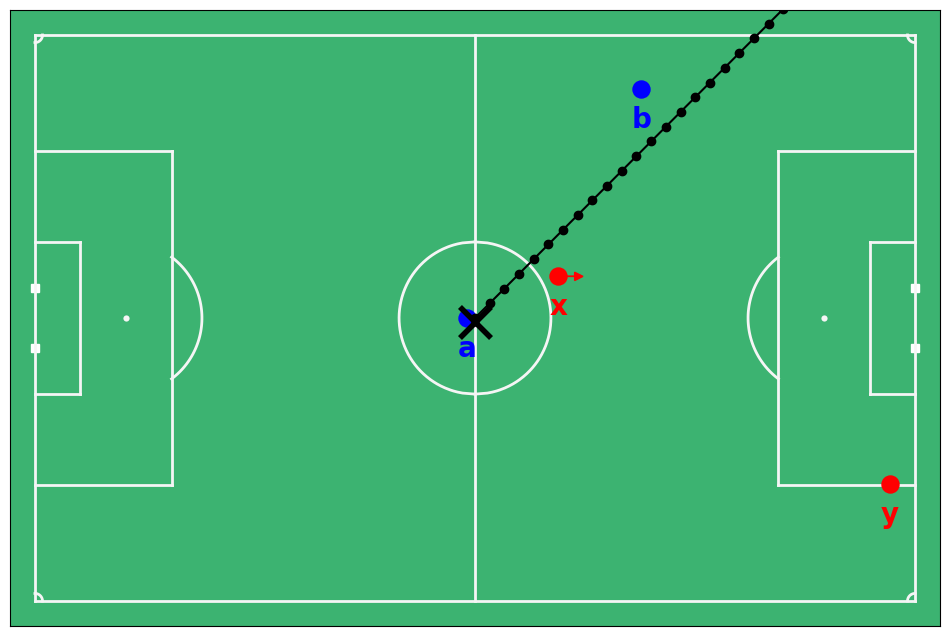

In [28]:
X_BALL_SIM = ball_x0 + math.cos(pass_angle) * D_BALL_SIM  # T
Y_BALL_SIM = ball_y0 + math.cos(pass_angle) * D_BALL_SIM  # T

### Plotting
plot_constellation_2d()
plt.plot(X_BALL_SIM, Y_BALL_SIM, "-o", label="Ball trajectory", color="black")
plt.show()

Since the physical simulation model treats the pass as a temporal process (i.e. the transition rates between the state "not intercepted" and the state "intercepted" is defined in terms of time), we need to transform the spatial grid into a temporal grid using a kinematic motion model for the ball. In this case, we choose to model it using constant speed, which simplifies our calculations and is a sufficient approximation of real-world ball kinematics.

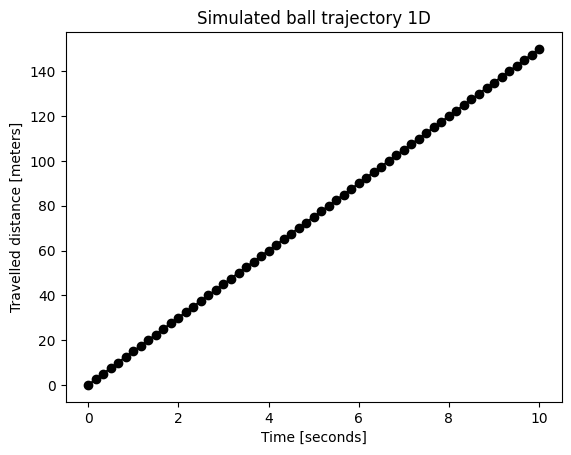

In [29]:
def time_to_arrive_1d(x, v, x_target):  # Function to calculate the time to go from x to x_target (with speed 'v')
    return (x_target - x) / v

T_BALL_SIM = time_to_arrive_1d(x=D_BALL_SIM[0], v=pass_speed, x_target=D_BALL_SIM)  # T

### Plotting
plt.plot(T_BALL_SIM, D_BALL_SIM, "-o", color="black")
plt.title("Simulated ball trajectory 1D")
plt.xlabel("Time [seconds]")
plt.ylabel("Travelled distance [meters]")
plt.show()

Now that we have set up the time and location grid of our example pass, we can move on to simulating the arrival times of the players. Comparing player and ball arrival times along the simulated trajectory will form the basis of our interception rates calculation.

#### Step 2: Players' time to arrive

The idea for obtaining player arrival times is to decompose their movement into two segments of constant velocity. The first segment is in the direction of the current motion and retains the player's speed while the second one is directed towards the target location with a fixed speed. This is the basic version of a model that has been shown to be effective in pinning down the reachable areas of players (Renkin, Bischofberger, Schikuta & Baca, 2022)$^5$ while remaining computationally efficient. Efficiency is key because arrival times have to be computed many times, that is, for every frame of every match and every player along every point of every simulated trajectory.

$^5$ Renkin, M., Bischofberger, J., Schikuta, E., & Baca, A. (2022). Validation and Optimisation of Player Motion Models in Football. In: International Conference on Computational Science (pp. 26-32).

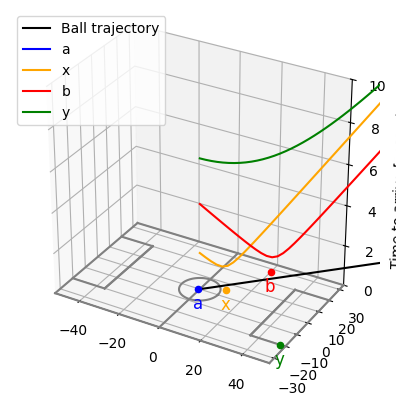

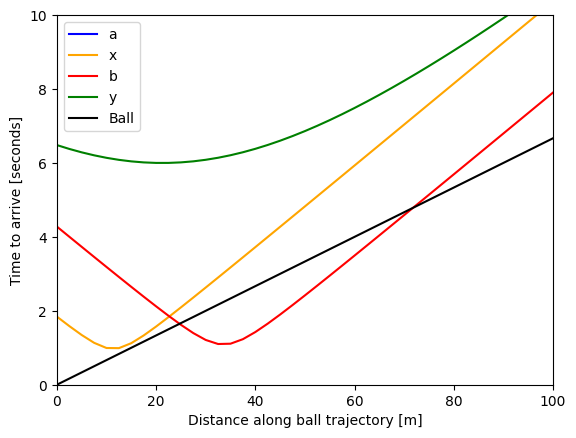

In [30]:
def approx_two_point_time_to_arrive(x, y, vx, vy, x_target, y_target, speed_segment2=9, inertial_seconds=0.5):
    x_mid, y_mid = x + vx * inertial_seconds, y + vy * inertial_seconds
    time_segment2 = np.sqrt((x_target - x_mid) ** 2 + (y_target - y_mid) ** 2) / speed_segment2
    return inertial_seconds + time_segment2

TTA_PLAYERS = approx_two_point_time_to_arrive(
    x=players_x[:, np.newaxis], y=players_y[:, np.newaxis], vx=players_vx[:, np.newaxis], vy=players_vy[:, np.newaxis],
    x_target=X_BALL_SIM[np.newaxis, :], y_target=Y_BALL_SIM[np.newaxis, :],
)  # P x T
# Our data has become 2-dimensional now, since we simulate arrival times of all players (dimension 1) along all points of the trajectory (dimension 2). To keep track of them, we indicate the dimensions of our numpy arrays with the following captial letters: P = players, T = simulation time.

# We exclude the passer by setting their arrival time to infinity. This is because a pass cannot be received by the passer him- or herself by definition. An exception is the calculation of a pass completion map where passes to oneself can be thought of as representing areas that are accessible by a carry.
TTA_PLAYERS[players == passer] = np.inf

# We use another helper function to plot our data both in 2D and 3D
import warnings

def double_plot(data, z_label="", data_names=None, dz=-0.75):
    plt.figure()
    figs = []
    ax = three_d_plot(dz)

    # Draw ball trajectory
    ax.plot(X_BALL_SIM, Y_BALL_SIM, 0, "-", label="Ball trajectory", color="black")
    ax.set_zlim(0, 10)
    ax.set_xlim(-52.5, 52.5)
    ax.set_ylim(-34, 34)

    if isinstance(data, list):
        for i, y in enumerate(data):
            ax.plot(X_BALL_SIM, Y_BALL_SIM, y, "-", label=data_names[i])

    elif len(data.shape) == 2:  # P x T
        for player in players:
            player_index = np.where(players == player)[0][0]
            ax.plot(X_BALL_SIM, Y_BALL_SIM, data[player_index, :], "-", color=player_colors[player_index], label=player)

    ax.set_zlabel(z_label)
    figs.append(FigAx(plt.gcf(), plt.gca()))
    plt.legend()

    plt.figure()
    ax = plt.gca()
    if isinstance(data, list):
        for i, y in enumerate(data):
            ax.plot(D_BALL_SIM, y, "-", label=data_names[i])
    elif len(data.shape) == 2:
        for player in players:
            player_index = np.where(players == player)[0][0]
            ax.plot(D_BALL_SIM, data[player_index], "-", color=player_colors[player_index], label=player)
    plt.ylabel(z_label)
    figs.append(FigAx(plt.gcf(), plt.gca()))
    plt.legend()

    return Figs(plot3d=figs[0], plot2d=figs[1])
    # return figs

### Plotting
warnings.simplefilter("ignore", category=RuntimeWarning)
figs = double_plot(TTA_PLAYERS, "Time to arrive [seconds]")
figs.plot2d.ax.plot(D_BALL_SIM, T_BALL_SIM, "-", color="black", label="Ball")
plt.xlim((0, 100))
plt.ylim((0, 10))
plt.xlabel("Distance along ball trajectory [m]")
plt.legend()
plt.show()

We can see that attacking player "b" has a lower arrival time between around 25m and 70m of travel distance of the pass, so "b" can intercept the ball comfortably during that segment. However, defender "x" gets close to the ball after around 10 meters, so he or she might be able to intercept the ball before "b". Player "y" never arrives earlier at a location than the ball and therefore has negligible chances to intercept the pass. Player "a" is the passer and therefore excluded from interception calculations because if the passer would intercept their own pass, we wouldn't call it a pass in the first place.

#### 3. Transform arrival times into interception rates

To turn arrival times into interception rates, we apply a sigmoid function to the difference between the arrival times of each player and the ball. The earlier you arrive before the ball, the higher your rate of interception. After a certain amount of time the rate levels off: Whether you arrive 5 seconds before the ball or 6 seconds should not make a big difference anymore for your likelihood to intercept.

The actual implementation of the model uses an approximate version of the sigmoid function that speeds it up significantly. Again, the goal is to make the most frequently executed steps of the model as efficient as possible.

We can examine the quality of the approximation visually, finding that the approximation gives us the S-shape we want while deviating from the classic sigmoid. For the rest of this tutorial, we use the exact sigmoid, but feel free to try out the approximation and see how the results change!

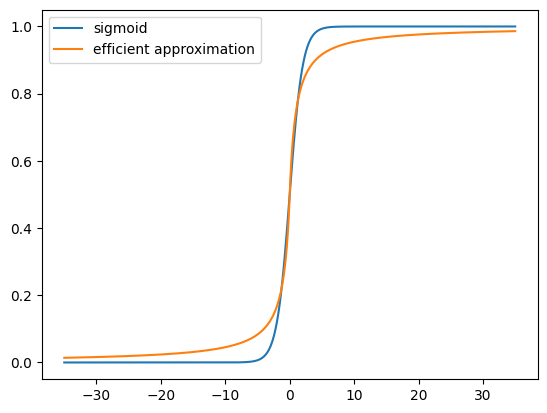

In [31]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def efficient_sigmoid(x):  # Computationally efficient approximation
    return 0.5 * (x / (1 + np.abs(x)) + 1)

x = np.linspace(-35, 35, 1000)
y = sigmoid(x)
y_approx = efficient_sigmoid(x)

plt.plot(x, y, label="sigmoid")
plt.plot(x, y_approx, label="efficient approximation")
plt.legend()
plt.show()

Now we are ready to calculate the intereption rates by inserting the difference between player arrival times ```TTA_PLAYER``` and ball arrival times ```T_BALL_SIM``` into the sigmoid. The sigmoid function has two parameters, $b_0$ and $b_1$. $b_0$ is related to the likelihood to be able to intercept when you arrive at the same time as the ball while $b_1$ is related to the rate at which the interception rate increases and decreases with earlier and later arrival times. An additional factor $\alpha$ scales the .

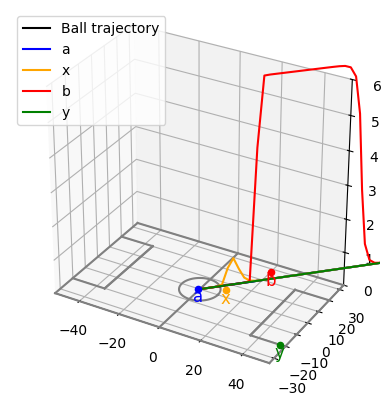

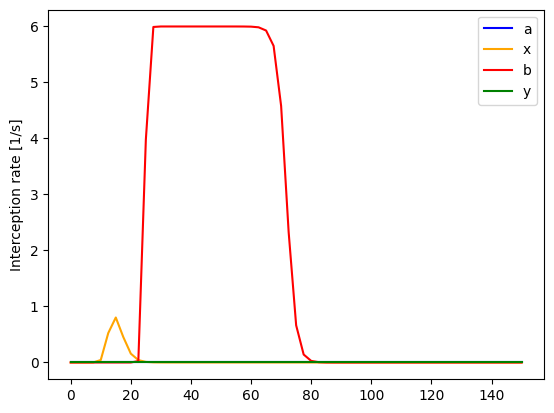

In [32]:
# Define model parameters b0 and b1 for the sigmoid function
b0 = 0
b1 = -15
alpha = 6

# Calculate interception rate from ball and player arrival times
interception_rate = alpha * sigmoid(b0 + b1 * (TTA_PLAYERS - T_BALL_SIM[np.newaxis, :]))  # P x T
# interception_rate = alpha * efficient_sigmoid(b0 + b1 * (TTA_PLAYERS - T_BALL_SIM[np.newaxis, :]))
interception_rate = np.nan_to_num(interception_rate, nan=0)  # P x T

figs = double_plot(interception_rate, "Interception rate [1/s]", dz=-0.25)
figs.plot3d.ax.set_zlim(0, 6)
plt.show()

We see that Player x's earlier pre-ball arrival between 25 and 70 meters translates into a high interception rate approaching the maximum interception rate. Player b also has a small peak with an interception rate of up to 1s<sup>-1</sup>.

As a sidenote: Given our gridsize of 2.5 meters and simulated ball speed of 15 meters per second, the highest possible interception rate is given by 1 / DT = 1 / (DX / v_ball) = 1 / (2.5/15) = 1/(1/6) = 6 s<sup>-1</sup>.

#### 3. Use interception rates to calculate probabilities

Given the interception probability of player r, we can finally calculate their interception probability $P_r(t)$ over time. Recall the solutions for the cumulated interception probabilities from above:

$$
P_0(t) = e^{\int_{0}^{t} \left(- \sum_{r \in R} a_r(\tau)\right) d\tau}
$$

$$
\text{for all } r \in R: \quad P_r(t) = \int_{0}^{t} a_r(\tau) P_0(\tau) d\tau
$$

Looking at the equation, we first need to calculate the probability $P_0$ that no player intercepted the pass along its trajectory. $P_0$ corresponds to the negative of the integral of the sum of interception rates, scaled by the exponential function. This makes sense: The higher the interception rate of all players, the higher the integral and the lower the probability $P_0$ that no one intercepted yet.

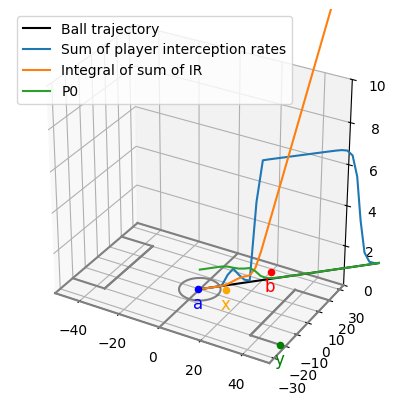

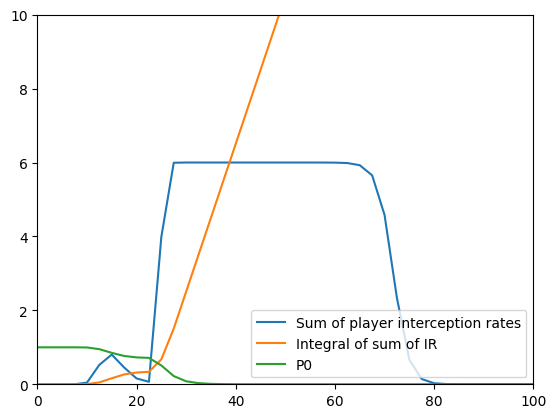

In [33]:
sum_ar = np.nansum(interception_rate, axis=0)  # T
int_sum_ar = scipy.integrate.cumulative_trapezoid(y=sum_ar, x=T_BALL_SIM, initial=0, axis=-1)
p0_cum = np.exp(-int_sum_ar)

figs = double_plot([sum_ar, int_sum_ar, p0_cum], "", data_names=["Sum of player interception rates", "Integral of sum of IR", "P0"])
figs[1].ax.set_ylim([0, 10])
figs[1].ax.set_xlim([0, 100])
plt.show()

In our example, the sum of interception rates effectively corresponds to the sum of the interception rates of players "b" and "x" which we saw earlier. Integrating these sums cumulatively gives us a monotonically rising curve (depicted in orange) that first rises slowly with x's small chances to intercept and skyrockets once we enter the area where b seems to have a very high chance to receive the pass. $P_0$ begins at a probability of 100% that the pass is not intercepted yet and decreases slowly and then quickly to zero. This is because the integral of the sums of interception rates appears in the exponent when calculating $P_0$, so the higher the integral, the closer $P_0$ gets to zero.

We can now easily calculate the interception probability density $\frac{dP_r(t)}{dt} = P_0(t) a_r(t)$ of player r.

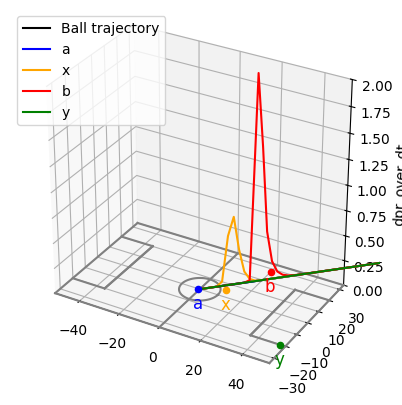

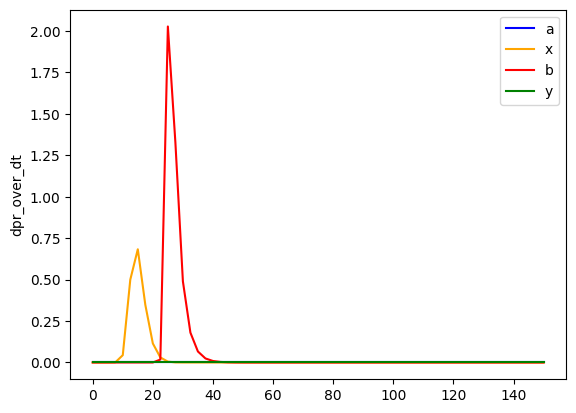

In [34]:
dpr_over_dt = p0_cum[np.newaxis, :] * interception_rate  # P x T
dpr_over_dt = np.nan_to_num(dpr_over_dt, nan=0)  # P x T

### Plotting
figs = double_plot(dpr_over_dt, "dpr_over_dt", dz=-0.15)
figs.plot3d.ax.set_zlim([0, 2])
plt.legend()
plt.show()

The interception density gives us the expected pattern that player x and player b have a significant likelihood to intercept the pass at different times.

Let's make another plot for only one player to see the relationship between interception rate, interception probability density and the cumulative probability P0.

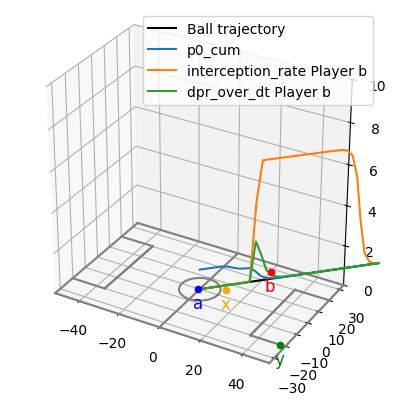

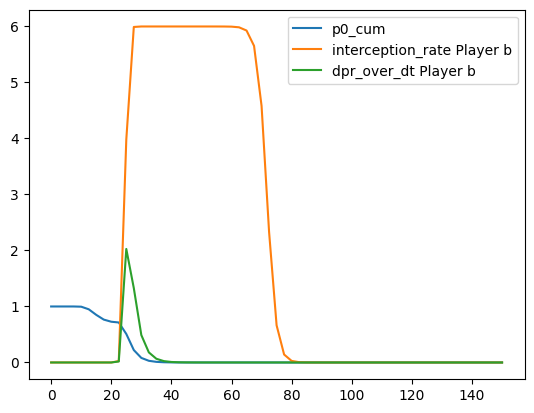

In [35]:
player_to_plot = "b"
i_player_to_plot = (players == player_to_plot)

double_plot([p0_cum, interception_rate[i_player_to_plot, :][0], dpr_over_dt[i_player_to_plot, :][0]], "", ["p0_cum", f"interception_rate Player {player_to_plot}", f"dpr_over_dt Player {player_to_plot}"])
plt.legend()
plt.show()

Here we can see that the probability density drops to zero once $P_0(t)$ is "depleted". This makes sense because once the pass has been almost certainly intercepted by someone, it cannot be intercepted a second time.

Now that we have the individual probability densities $\frac{dP_r(t)}{dt}$, we can easily obtain cumulative player-level interception probabilities $P_r(t)$ via integration.

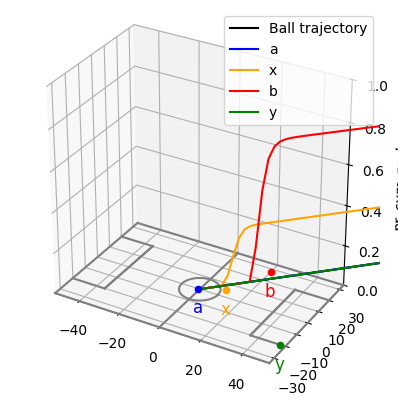

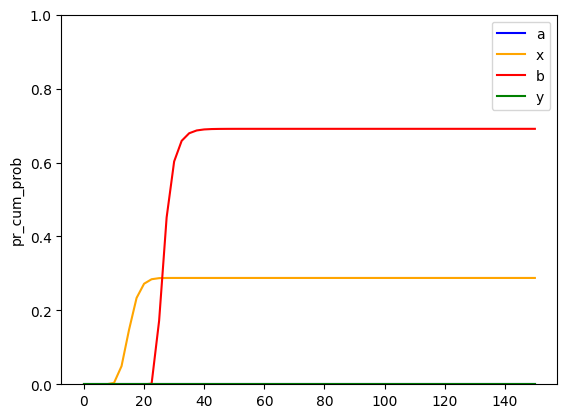

In [36]:
pr_cum_prob = scipy.integrate.cumulative_trapezoid(y=dpr_over_dt, x=T_BALL_SIM, initial=0, axis=-1)
figs = double_plot(pr_cum_prob, "pr_cum_prob", dz=-0.1)
figs[0].ax.set_zlim([0, 1])
figs[1].ax.set_ylim([0, 1])
plt.show()

In order to use our simulated probability densities in a spatial context, we need to transform them from time to space.

In [37]:
DT = T_BALL_SIM[1] - T_BALL_SIM[0]  # F x V0, works only because we simulate with constant speed
DX = radial_gridsize  # works because we have a uniform grid
dpr_over_dx = dpr_over_dt * DT / DX

The final step to get the expected interception rate for the pass is to transform the probabilities and densities from the player level to the team level by aggregating over all members of each team (attacking and defending team).

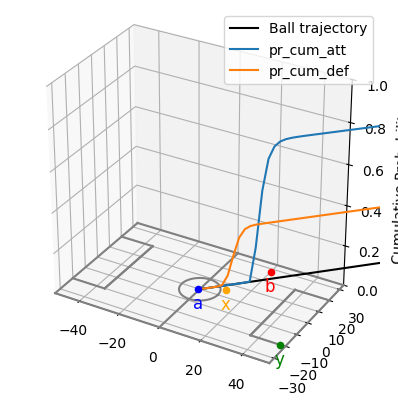

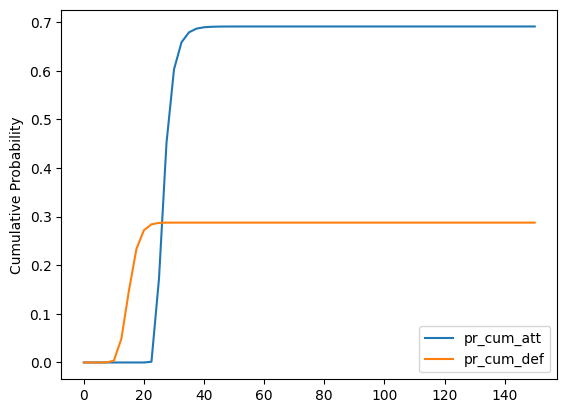

In [38]:
player_is_attacking = passer_team == teams  # P

dpr_over_dx_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], dpr_over_dx, 0), axis=0)
dpr_over_dx_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], dpr_over_dx, 0), axis=0)
# dp0_over_dt = -p0_cum * sum_ar  # F x V0 x PHI x T
# dp0_over_dx = dp0_over_dt * DT / DX

pr_cum_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], pr_cum_prob, 0), axis=0)
pr_cum_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], pr_cum_prob, 0), axis=0)

figs = double_plot([pr_cum_att, pr_cum_def], "Cumulative Probability", ["pr_cum_att", "pr_cum_def"], dz=-0.075)
figs.plot3d.ax.set_zlim([0, 1])
plt.show()

We are done! The last value (in terms of simulation time) of the cumulative interception probability of the attacking team is the Expected Completion (xC) rate of the pass! In this case, it is 69.1%, as shown below.

If we want, we can also calculate the location of the most likely interception, per player, per team or in general. In this example, we calculate the most likely location of interception per player.

Expected completion: 69.1%
Expected interception: 28.8%
Expected out: 0.0%


<Figure size 640x480 with 0 Axes>

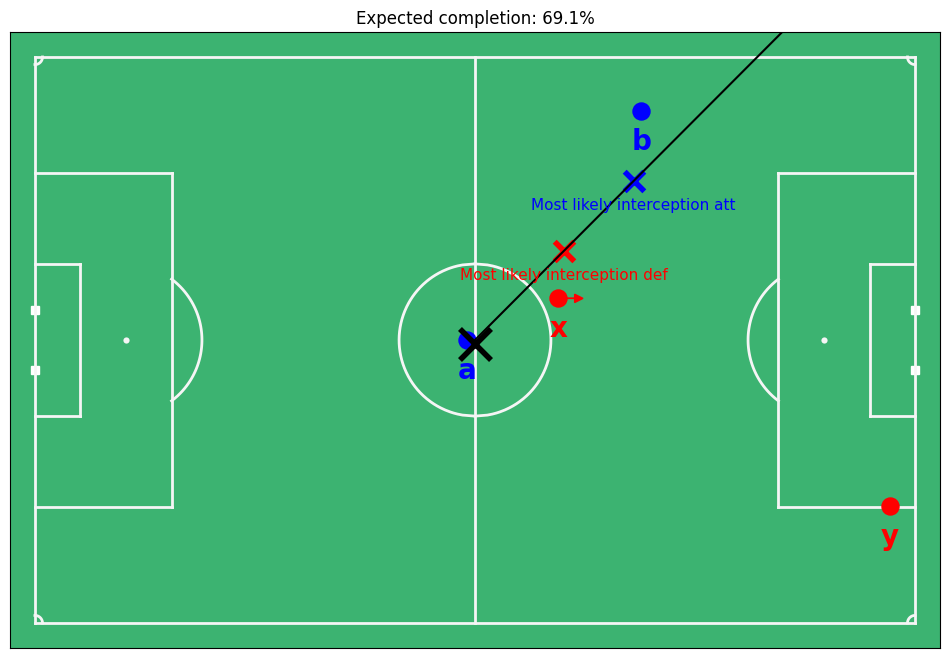

In [39]:
xc = pr_cum_att[-1]

print(f"Expected completion: {xc:.1%}")
print(f"Expected interception: {pr_cum_def[-1]:.1%}")
print(f"Expected out: {p0_cum[-1]:.1%}")

# Predict the most likely interception location on the team-level
team_to_most_likely_interception_location = {}
for team, dpr in [("att", dpr_over_dx_att), ("def", dpr_over_dx_def)]:
    mean_distance = np.sum(dpr * D_BALL_SIM) / np.sum(dpr)
    most_likely_interception_x = ball_x0 + math.cos(pass_angle) * mean_distance
    most_likely_interception_y = ball_y0 + math.sin(pass_angle) * mean_distance
    team_to_most_likely_interception_location[team] = (most_likely_interception_x, most_likely_interception_y)

### Plotting
plot_constellation_2d()
plt.plot(X_BALL_SIM, Y_BALL_SIM, "-", label="Ball trajectory", color="black")
for team, (x, y) in team_to_most_likely_interception_location.items():
    plt.scatter(x, y, label=f"Most likely interception {team}", color={"att": "blue", "def": "red"}[team], s=200, marker="x", linewidths=4)
    plt.text(x, y-2, f"Most likely interception {team}", fontsize=11, ha="center", va="top", color={"att": "blue", "def": "red"}[team])

plt.title(f"Expected completion: {xc:.1%}")
plt.show()

Expected completion is the bread-and-butter result of every pass completion model, so our physical model produces it too. However, if xC is all you care about, you are better off using a machine learning model (see Bischofberger & Baca, 2025)$^1$. The real power of physical simulation lies in extrapolating to rare scenarios where purely data-driven approaches fail. When we calculate pass completion rates all over the pitch for example, most of the results correspond to rare or impossible passes that never appear in the data, so you cannot assume that a machine learning regressor that is primarily driven by data will produce meaningful results for these data points. Physical simulation gives you more robust estimates in these situations, allowing us to finally derive Dangerous Accessible Space (DAS).

### Dangerous accessible space

In order to calculate DAS, we simulate passes with different angles (and speeds if we want) into a <b>pass completion map</b> that shows which areas on the pitch can be successfully accessed by a pass. The area integral of this map is called <b>accessible space</b> (AS). The area integral of the pass completion map weighted with a measure of threat is called <b>dangerous acccessible space</b> (DAS) and can be used to measure the value of actions and situations.

An important caveat in this step is that compared to expected completion, we don't care anymore about the <i>probability</i> that a pass is intercepted somewhere. We care about all the locations where a pass is <i>possible</i>. This is an important difference that affects how the interception rates are processed. The basic idea is that the interception rates of your own teammates don't affect your possibility to intercept as they can just let the ball roll instead of eagerly intercepting it. Therefore, we split the interception rates by team and use only the interception rates of the opponent team to calculate the possibility density.

This is how it works in code:

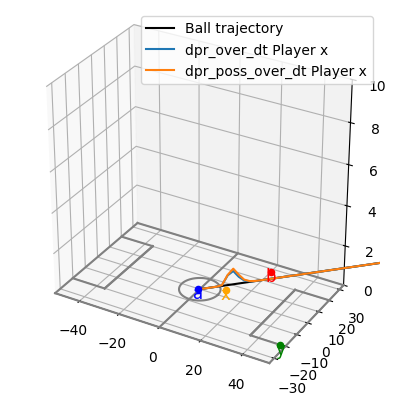

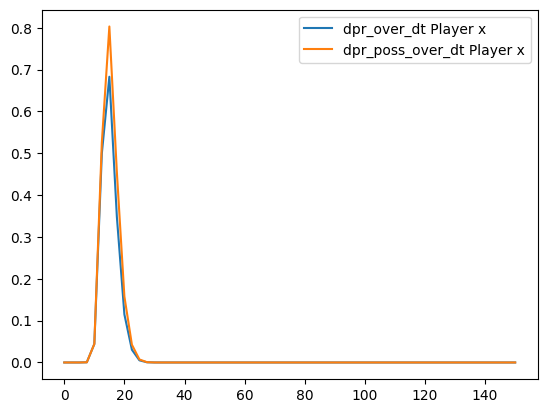

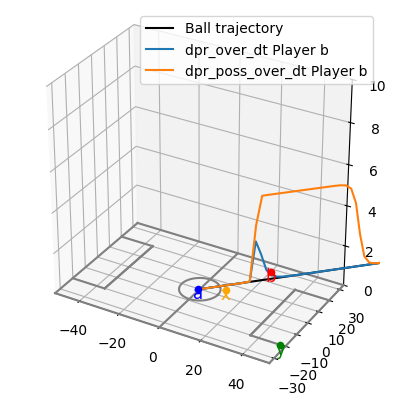

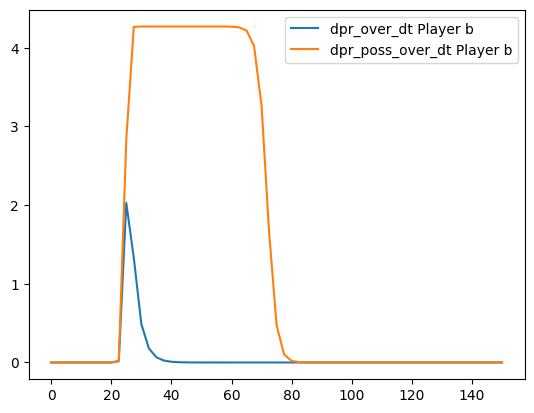

In [40]:
sum_ar_att = np.nansum(np.where(player_is_attacking[:, np.newaxis], interception_rate, 0), axis=0)  # T
sum_ar_def = np.nansum(np.where(~player_is_attacking[:, np.newaxis], interception_rate, 0), axis=0)  # T
int_sum_ar_att = scipy.integrate.cumulative_trapezoid(y=sum_ar_att, x=T_BALL_SIM, initial=0, axis=-1)  # T
int_sum_ar_def = scipy.integrate.cumulative_trapezoid(y=sum_ar_def, x=T_BALL_SIM, initial=0, axis=-1)  # T
p0_cum_only_att = np.exp(-int_sum_ar_att)  # T
p0_cum_only_def = np.exp(-int_sum_ar_def)  # T
p0_only_opp = np.where(  # P x T, a version of P0 that only gets decreased by the interception rates of the opponent team of the respective player.
    player_is_attacking[:, np.newaxis],
    p0_cum_only_def[np.newaxis, :], p0_cum_only_att[np.newaxis, :]
)
dpr_poss_over_dt = p0_only_opp * interception_rate  # P x T

### Plotting
figs = double_plot([dpr_over_dt[1], dpr_poss_over_dt[1]], "", ["dpr_over_dt Player x", "dpr_poss_over_dt Player x"], dz=-0.25)
figs = double_plot([dpr_over_dt[2], dpr_poss_over_dt[2]], "", ["dpr_over_dt Player b", "dpr_poss_over_dt Player b"], dz=-0.25)

dpr_over_dx_poss = dpr_poss_over_dt * DT / DX
# Team-level aggregation: Use maximum instead of sum to aggregate possibilities
dpr_over_dx_att_poss = np.nanmax(np.where(player_is_attacking[:, np.newaxis], dpr_over_dx_poss, 0), axis=0)
dpr_over_dx_def_poss = np.nanmax(np.where(~player_is_attacking[:, np.newaxis], dpr_over_dx_poss, 0), axis=0)

If you compare the interception probability with the interception possibility, you can see that possibility is generally retained longer. For player b, the possibility to intercept remains at a high level for a longer amount of time because there is no defender around and player b could wait and receive the ball at different locations further down the trajectory. This is exactly what we need when we discuss accessible space - not just the space where it is most likely to intercept given players run to the ball as fast as possible, but the entire space where it is <i>possible</i> to receive a pass.

If you repeat the calculation of attacking possibility densities for many different angles, you obtain data points not just along one trajectory but across the entire pitch. This is a <b>pass completion map</b>, a spatial representation of the accessibility of various spaces.

Extending the pass simulations demonstrated in this notebook to multiple angles is relatively trivial (you just need to add the passing angle as an extra dimension to all calculations). Yet, to keep the code tidy, we will simply use the ```accessible-space``` package to perform the calculations.

#### Accessible Space

To calculate the pass completion map with ```accessible-space```, we only need tracking data. However, this data needs two extra columns: First, we need to add information about which team is in possession so the model knows who is attacking and who is defending. And second, we need to add the attacking direction which is later used to calculate threat. For real data, the attacking direction can be inferred automatically by the ```accessible-space``` package based on average player positions.

In [41]:
# Additional columns necessary to compute DAS
df["ball_possession"] = "H"  # In the real world, you get this information from either event data, tracking data (some providers) or you can calculate your own possession model on tracking data.
df["attacking_direction"] = 1  # For real data, the accessible_space module also offers an automatic detection of attacking direction based on the X coordinate of the team centroids (through the infer_attacking_direction parameter).

The interface of ```accessible-space``` has very few requirements for the structure of the data: You simply give it a Pandas data frame and tell it the names of the relevant columns. The return value is a named tuple that contains both the aggregated results such as the amount of accessible space in square meters and the raw ```simulation_result``` which contains various numpy arrays with the raw simulated probabilities and possibilities.

Simulating passes: 100%|██████████| 1/1 [00:00<00:00,  1.06chunk/s]


Accessible space: 4681m²


<Figure size 640x480 with 0 Axes>

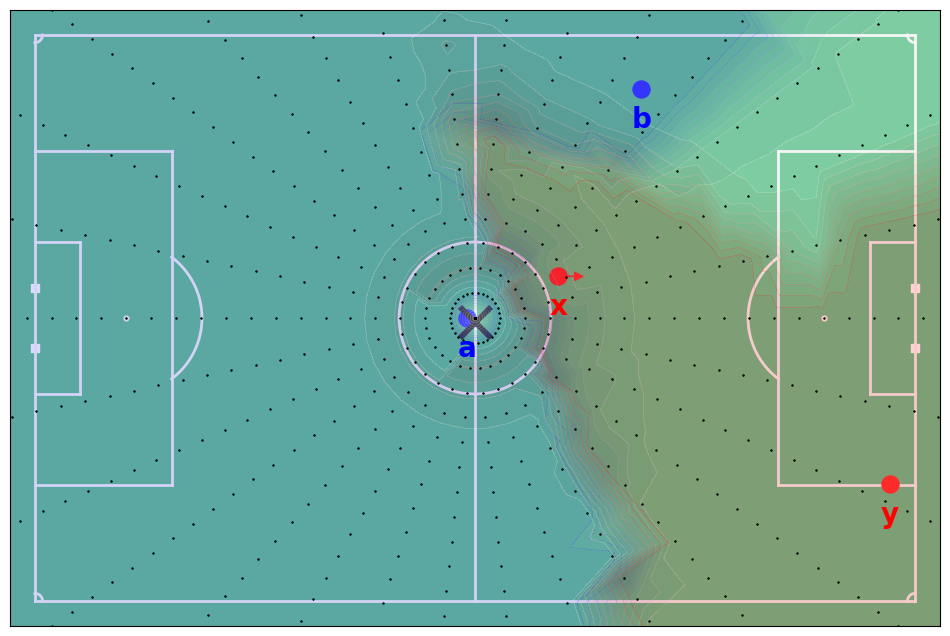

In [42]:
import sys, os
# sys.path.append(os.path.dirname(__file__), "../..")
sys.path.insert(0, "C:/Users/j.bischofberger/Downloads/accessible_space_package-20241206T091605Z-001/accessible-space")

import accessible_space

ret = accessible_space.get_dangerous_accessible_space(
    df, frame_col="frame_id",
    player_col="player", team_col="team", period_col=None, respect_offside=False,
    #tracking_player_id="ball", tracking_x_col="x", tracking_y_col="y", tracking_vx_col="vx", tracking_vy_col="vy", attacking_direction_col="attacking_direction", possession_team_col="ball_possession", radial_gridsize=1, v0_min=1, v0_max=25, n_v0=70,
    return_cropped_result=False,
    additional_fields_to_return=["defense_poss_density"],  # This needs additional calculation and is therefore not returned by default
    n_v0=90  # a model parameter to increase resolution (number of
)
df["AS"] = ret.acc_space
df["frame_index"] = ret.frame_index
simulation_result = ret.simulation_result

print(f"Accessible space: {df['AS'].iloc[0]:.0f}m²")

# Using accessible_space, we can also plot the resulting possibility surface
plot_constellation_2d()
fig = accessible_space.plot_expected_completion_surface(simulation_result, frame_index=df["frame_index"].iloc[0], attribute="attack_poss_density", color="blue")
fig = accessible_space.plot_expected_completion_surface(simulation_result, frame_index=df["frame_index"].iloc[0], attribute="defense_poss_density", color="red")

Accessible space is the physically grounded analog to a quantity called <b>space control</b>. Buther than space control that relies on fuzzy notions like "control" and "influence", accessible space represents a properly defined quantity: To control space means to be able to receive a pass within that space.

By weighting the pass completion map by a measure of value and then calculating the area integral, we obtain Dangerous Accessible Space (DAS). DAS takes into account both the accessibility and threat of the available space in a given situation.

Dangerous accessible space: 2.3m²


<Figure size 640x480 with 0 Axes>

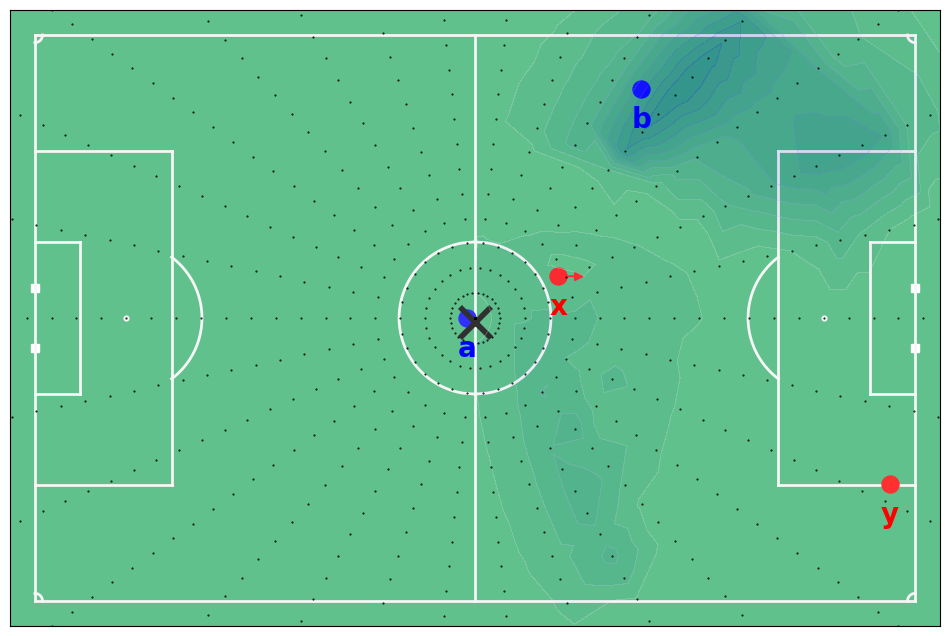

In [43]:
df["DAS"] = ret.das
dangerous_result = ret.dangerous_result

print(f"Dangerous accessible space: {df['DAS'].iloc[0]:.1f}m²")

plot_constellation_2d()
fig = accessible_space.plot_expected_completion_surface(
    dangerous_result, frame_index=df["frame_index"].iloc[0]
)

In this example, DAS amounts to a value of about 2 square meters and, unsurprisingly, picks out the pass to player b as a dangerous option in that situation.

This is it! The ```accessible-space``` package allows you to calculate useful metrics based on this model, such as DAS Gained (```get_das_gained```) or per-player DAS values (```get_individual_dangerous_accessible_space```) which can directly be used to create advanced insight into player and team performance!

Go back to the repository:
[https://github.com/jonas-bischofberger/accessible-space](https://github.com/jonas-bischofberger/accessible-space)